# LeNet

This notebook trains the LeNet-5 neural network on the MNIST database.

#### Imports

In [155]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import random
import re
import time
from typing import Any, Dict
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from models.torch_lenet import TorchLeNet
import src.data.data as data

importlib.reload(data)
importlib.reload(src)

SEED = 12

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Training

In [152]:
_framework = "torch"  #@param ["torch", "jax"]
_val_split = 0.1  #@param
_rotation_degrees = 0  #@param
_crop_padding = 0  #@param
_duplicate_with_augment = False  # Adds --duplicate_with_augment flag
_init = "kaiming"  #@param ["orthogonal", "kaiming", "xavier"]
_optimizer = "adamw"  #@param ["sgd", "adam", "adamw"]
_activation = "relu"  #@param ["relu", "tanh", "sigmoid"]
_lr = 3e-4  #@param
_seed = SEED  #@param


model_path = f'src/models/ckpts/lenet_{_framework}_{_val_split}_{_rotation_degrees}_{_crop_padding}_{_duplicate_with_augment}_{_init}_{_optimizer}_{_activation}_{_lr}_{_seed}.pth'
print(model_path)

src/models/ckpts/lenet_torch_0.1_0_0_False_kaiming_adamw_relu_0.0003_12.pth


In [150]:
! python src/train.py --framework={_framework} \
    --val_split={_val_split} \
    --rotation_degrees={_rotation_degrees} \
    --crop_padding={_crop_padding} \
    {"--duplicate_with_augment" if _duplicate_with_augment else ""} \
    --init={_init} \
    --optimizer={_optimizer} \
    --activation={_activation} \
    --lr={_lr} \
    --seed={_seed}

---------------------------------------------
Framework:                  torch
Validation Split:           0.1
Rotation Degrees:           0
Crop Padding:               0
Duplicate with Augment:     False
Init method:                kaiming
Optimizer:                  adamw
Activation:                 relu
Learning Rate:              0.0003
Random Seed:                12
---------------------------------------------
Train: Dataset MNIST
    Number of datapoints: 54000

Val: Dataset MNIST
    Number of datapoints: 6000
Test: Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[tensor(0.1307)], std=[tensor(0.3081)])
           )

---------------------------------------------
TorchLeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): C

### Evaluation

In [153]:
from models.torch_lenet import TorchLeNet

print(f'Loading model at: {model_path}')

def get_model_params(model_path: str) -> Dict[str, Any]:
    model_params = model_path.replace(".pth", "").split("_")
    assert len(model_params) == 11
    
    params_dict = {}
    params_dict["framework"] = model_params[1]
    params_dict["val_split"] = float(model_params[2])
    params_dict["rotation_degrees"] = int(model_params[3])
    params_dict["crop_padding"] = int(model_params[4])
    params_dict["duplicate_with_augment"] = model_params[5]
    params_dict["init"] = model_params[6]
    params_dict["optimizer"] = model_params[7]
    params_dict["activation"] = model_params[8]
    params_dict["lr"] = float(model_params[9])
    params_dict["seed"] = int(model_params[10])

    return params_dict
    
# Load model
model_params = get_model_params(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lenet5 = TorchLeNet(act_fn=model_params["activation"], init=model_params["init"]).to(device)
lenet5.load_state_dict(torch.load(model_path))

Loading model at: src/models/ckpts/lenet_torch_0.1_0_0_False_kaiming_adamw_relu_0.0003_12.pth


<All keys matched successfully>

In [156]:
_train_dataset, test_dataset, _val_dataset = data.get_MNIST() # TODO: Add quiet fetching or test-only

test_x = test_dataset.data.unsqueeze(1).float()
test_y = test_dataset.targets

lenet5.eval()
with torch.no_grad():
    test_x, test_y = test_x.to(device), test_y.to(device)
    logits = lenet5(test_x)
    test_preds = logits.argmax(axis=1)
    accuracy = (test_preds == test_y).sum() / len(test_y)

print(f'Test Set Accuracy: {100 * accuracy:.2f}%')

Train: Dataset MNIST
    Number of datapoints: 54000

Val: Dataset MNIST
    Number of datapoints: 6000
Test: Dataset MNIST
    Number of datapoints: 10000
    Root location: src/data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[tensor(0.1307)], std=[tensor(0.3081)])
           )

Test Set Accuracy: 94.52%


### Ablations

### Interpretability

#### Saliency Maps

In [157]:
def saliency_map(model, x, y, grad_times_input=False):
    """
    Returns a saliency map (∂ score_y / ∂ x) for a given model, input, and label.

    Args:
        model (nn.Module): Classifier
        x (tensor): CxHxW normalized image
        y (int): Class index (target label)
        grad_times_input (bool): If true, returns a gradient x input saliency map. (input * ∂ score_y / ∂ x)

    Returns:
        saliency (np.ndarray): Saliency map.
    """
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    x = x.clone().detach().to(device)
    if x.ndim == 3:      
        x = x.unsqueeze(0)  # Add batch dim if needed
    y = torch.tensor([int(y)], device=device)

    x.requires_grad_(True)  # Enable input gradients
    model.zero_grad(set_to_none=True)  # Set gradients to 0

    with torch.enable_grad():
        logits = model(x)
        score_y = logits.gather(1, y.view(-1,1)).squeeze()
        score_y.backward()

    saliency = x.grad
    if (grad_times_input):
        saliency = (saliency * x.detach())
    saliency = saliency.detach().abs().squeeze()
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)  # Normalize to [0,1] for visualization
    return saliency.cpu()

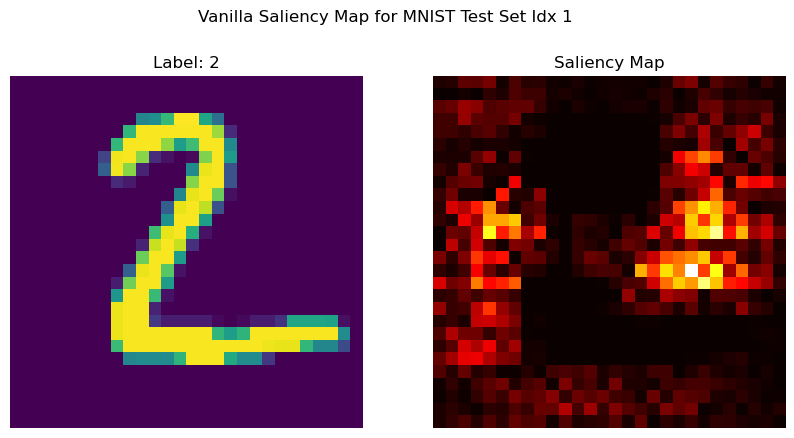

In [159]:
test_idx = 1  #@param

x, y = test_x[test_idx], test_y[test_idx]

sal = saliency_map(lenet5, x, y)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle(f'Vanilla Saliency Map for MNIST Test Set Idx {test_idx}')
ax[0].imshow(x.squeeze()); ax[0].set_title(f'Label: {y}'); ax[0].axis("off");
ax[1].imshow(sal.numpy(), cmap="hot"); ax[1].set_title(f'Saliency Map'); ax[1].axis("off"); plt.show()

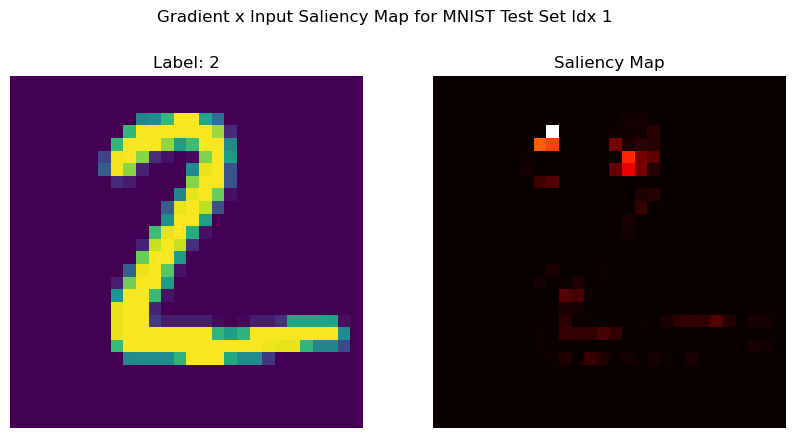

In [109]:
# Notice how the digit pixels have the lowest gradient.
# In an attempt to highlight which parts of the writing contribute to the class, we can visualize Gradient × Input
inp_sal = saliency_map(lenet5, x, y, grad_times_input=True)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle(f'Gradient x Input Saliency Map for MNIST Test Set Idx {test_idx}')
ax[0].imshow(x.squeeze()); ax[0].set_title(f'Label: {y}'); ax[0].axis("off");
ax[1].imshow(inp_sal.numpy(), cmap="hot"); ax[1].set_title(f'Saliency Map'); ax[1].axis("off"); plt.show()

#### GradCAM

In [113]:
import torch.nn.functional as F
from typing import Optional, Union

def grad_cam(
    model: torch.nn.Module,
    input_tensor: torch.Tensor,
    target_layer: Union[str, torch.nn.Module],
    target_class: Optional[int] = None,
    normalize: bool = True,
) -> torch.Tensor:
    """
    Compute a Grad-CAM heatmap for a given model and input.

    Args:
        model: PyTorch model (produces class scores/logits).
        input_tensor: Tensor of shape (N, C, H, W). N can be 1+ (returns one CAM per item).
        target_layer: Layer (module) or dotted name of the layer to probe (e.g. 'layer4.2.relu').
        target_class: Class index to explain. If None, uses model's argmax per item.
        normalize: If True, min-max normalize CAMs to [0, 1] per item.

    Returns:
        cam: Tensor of shape (N, H, W) aligned to input spatial size.
    """
    model.eval()

    # Resolve target layer if passed as string
    if isinstance(target_layer, str):
        module = model
        for attr in target_layer.split('.'):
            if attr.isdigit():
                module = module[int(attr)]  # handle Sequential/ModuleList index
            else:
                module = getattr(module, attr)
        target_module = module
    else:
        target_module = target_layer

    # Storage for activations & gradients
    activations = []
    gradients = []

    def fwd_hook(_m, _i, o):
        activations.append(o.detach())

    def bwd_hook(_m, gi, go):
        # go is a tuple; grab grad wrt output (same shape as activation)
        gradients.append(go[0].detach())

    # Register hooks
    fwd_handle = target_module.register_forward_hook(fwd_hook)
    bwd_handle = target_module.register_full_backward_hook(bwd_hook)

    # Forward
    logits = model(input_tensor)
    if logits.ndim == 1:
        logits = logits.unsqueeze(0)  # (N, num_classes)

    # Determine target indices per item
    if target_class is None:
        target_idxs = logits.argmax(dim=1)
    else:
        target_idxs = torch.full((logits.shape[0],), int(target_class), device=logits.device, dtype=torch.long)

    # Build scalar objective: sum over batch of the selected class scores
    gather = logits.gather(1, target_idxs.view(-1, 1)).sum()

    # Backward (compute grads wrt target layer)
    model.zero_grad(set_to_none=True)
    gather.backward(retain_graph=False)

    # Clean up hooks
    fwd_handle.remove()
    bwd_handle.remove()

    if not activations or not gradients:
        raise RuntimeError("Failed to capture hooks; check target_layer is used by the forward pass.")

    A = activations[-1]           # (N, C, h, w)
    dY_dA = gradients[-1]         # (N, C, h, w)

    # Compute channel weights via global average pooling of gradients
    weights = dY_dA.mean(dim=(2, 3), keepdim=True)      # (N, C, 1, 1)

    # Weighted combination and ReLU
    cam = (weights * A).sum(dim=1)                      # (N, h, w)
    cam = F.relu(cam)

    # Upsample to input spatial size
    H, W = input_tensor.shape[-2:]
    cam = cam.unsqueeze(1)
    cam = F.interpolate(cam, size=(H, W), mode="bilinear", align_corners=False).squeeze(1)

    if normalize:
        # Normalize per item to [0,1]
        cam_min = cam.flatten(1).min(dim=1)[0].view(-1, 1, 1)
        cam_max = cam.flatten(1).max(dim=1)[0].view(-1, 1, 1)
        denom = (cam_max - cam_min).clamp(min=1e-12)
        cam = (cam - cam_min) / denom

    return cam.detach()

In [ ]:
grad_cam(
    model=lenet5,
    input_tensor=x,
    target_layer=lenet5.pool2,
    target_class=y,
    normalize=True,
)

In [112]:
print(lenet5)

TorchLeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (act_fn): ReLU()
)


#### Sparse Autoencoders (SAEs)

### Adversarial Examples